# PPE tower analysis
- Daniel Kennedy (djk2120@ucar.edu)
- updated March 3, 2022

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import statsmodels.api as sm
import os

### optional: set up your PBSCluster
- not necessary if you are working with preprocessed data
- client.cluster will show when your workers are active
- note it can take a few minutes to get through the job queue
- set up to ask for 3hrs, but can be increased

In [2]:
# Setup your PBSCluster

project = 'P93300641' #input your project code

cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='25GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB', # Specify resources
    project=project, # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(20)

# Setup your client
client = Client(cluster)

In [3]:
## wait until workers >0
client.cluster

In [6]:
topdir = '/glade/scratch/djk2120/PPEn11/hist/amflx/'
files = sorted(glob.glob(topdir+'*.nc'))[1:]
lhckey = '/glade/scratch/djk2120/PPEn11/amflx_lhc/lhc_220324.txt'
df = pd.read_csv(lhckey)

In [8]:
def preprocess(ds,singles=False):
    datavars = ['FPSN','EFLX_LH_TOT','VEGWP','SOILWATER_10CM','TWS','BTRAN','SMP','H2OSOI']
    onecopy  = ['RAIN','SNOW','FSDS','mcsec']
    nt = len(ds.time)
    ix = np.arange(nt)<nt-1 #first timestep is not meaningful
    if singles:
        ds2 = ds[onecopy].shift(time=-1).isel(time=ix,lndgrid=0)
    else:
        ds2 = ds[datavars].shift(time=-1).isel(time=ix,lndgrid=0)
    return ds2

In [9]:
ds0 = preprocess(xr.open_dataset(files[0]),singles=True)
ds = xr.open_mfdataset(files,combine='nested',concat_dim='ens',
                       parallel=True,preprocess=preprocess)
for dv in ds0.data_vars:
    ds[dv]=ds0[dv]

In [19]:
x = ds.TWS.mean(dim='time').compute()

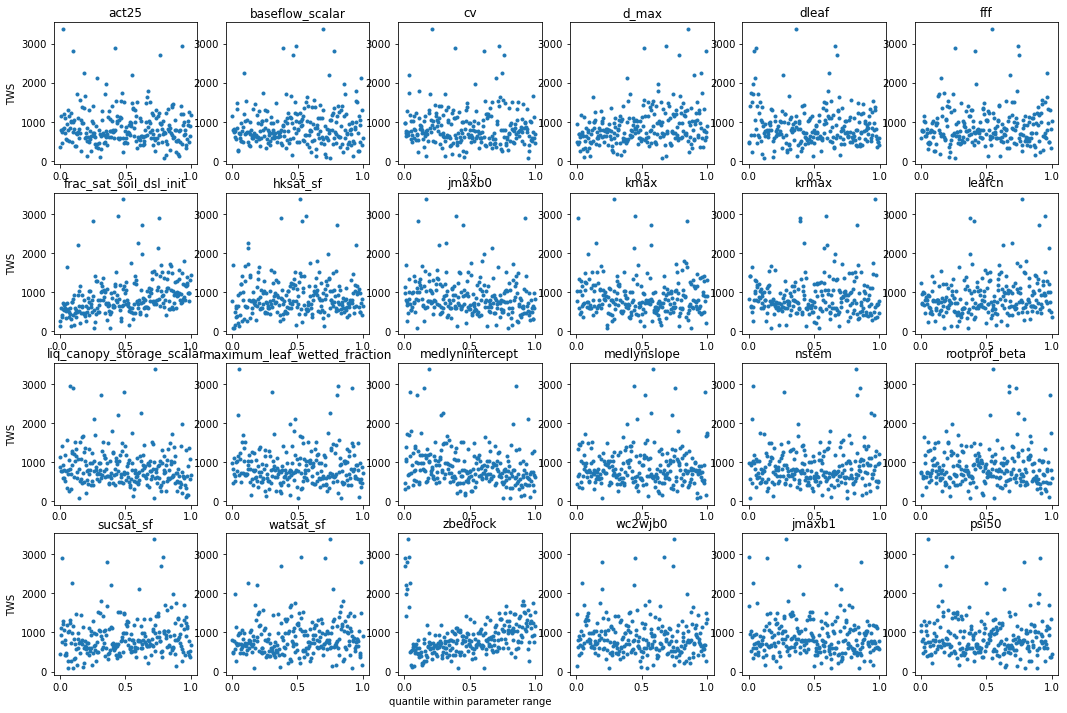

In [20]:
plotter(x)